In [93]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import trange
import simple_env
import gym

import actor_critic
import importlib
importlib.reload(actor_critic)
importlib.reload(simple_env)
from actor_critic import ActorCritic, EnvBatch

In [94]:
from gym import ObservationWrapper

class PendulumWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)        
        self.action_space = env.action_space
        self.observation_space = gym.spaces.Box( low=np.array(  [-np.pi, env.observation_space.low[2] ] ), 
                                                 high=np.array( [+np.pi, env.observation_space.high[2] ]) )
        
    def observation(self, obs):
        """Get the value of theta from the sin and cos.
        Use theta in the interval [-pi, +pi ]."""
        theta = ( np.math.atan2( obs[1], obs[0] ) + np.pi % (2*np.pi) ) - np.pi
        theta_dot = obs[2]
        return np.array([ theta, theta_dot ])

In [95]:
env_init_fun = lambda : PendulumWrapper( gym.make( 'Pendulum-v0') )
env = EnvBatch(env_init_fun)

In [96]:
lin_feature_func = lambda x : np.vstack( [ np.ones( (x.shape[0],) ), 
                                           np.cos(x[:,0]),
                                           x[:,1], 
                                           np.cos(2 * x[:,0]),
                                           x[:,1] ** 2, 
                                           x[:,1] * np.cos(x[:,0])
                                        ] ).T

actor = actor_critic.ActorLinear(feature_func=lin_feature_func, env=env,
                      scale_model_inputs=True, activation='elu')
critic = actor_critic.CriticLinear(feature_func=lin_feature_func, env=env,
                      scale_model_inputs=True, activation='elu')
ac = ActorCritic(
                 env=env,
                 entropy_coef=0.001,
                 actor=actor, 
                 critic=critic,
                 actor_learning_rate=0.0001,
                 critic_learning_rate=0.0001
                )

W1227 19:10:03.069187 4750800320 base_layer.py:1814] Layer V is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



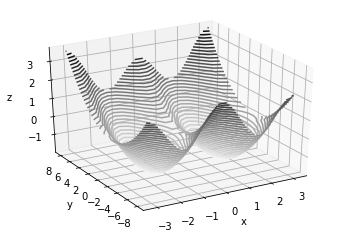

In [97]:
from mpl_toolkits import mplot3d

n_splits = [ 20, 20 ]
wenv = env.envs[0]
x = np.linspace( wenv.observation_space.low[0], wenv.observation_space.high[0], num=n_splits[0] )
y = np.linspace( wenv.observation_space.low[1], wenv.observation_space.high[1], num=n_splits[1] )

X, Y = np.meshgrid( x, y )
coords = np.array(list(zip( X.ravel(), Y.ravel() )))
res = ac.critic.model.predict(coords)
Z = res.numpy().reshape(n_splits)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

ax.view_init(30, -120)

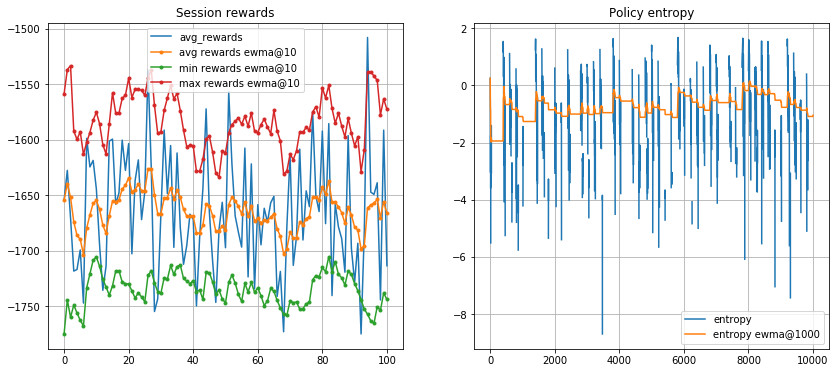





100%|██████████| 10001/10001 [06:01<00:00, 27.69it/s]

([-1654.2803790847665,
  -1627.5694761912428,
  -1670.345766402587,
  -1718.2784550130584,
  -1716.804221185673,
  -1699.247497035447,
  -1747.082624547911,
  -1598.6688284727709,
  -1624.4299844994657,
  -1618.5702078365675,
  -1644.3583513052715,
  -1694.927707212484,
  -1735.576238859905,
  -1713.81497213674,
  -1601.2113032855548,
  -1599.3857786077733,
  -1658.039064157558,
  -1647.861064171155,
  -1600.2978699632295,
  -1627.5667676695587,
  -1603.4164993772702,
  -1702.7122308780124,
  -1636.664747320185,
  -1618.1051840027628,
  -1671.8987207925684,
  -1646.9268163060103,
  -1537.049713978912,
  -1624.9536627535854,
  -1754.6852414582754,
  -1743.4193994567702,
  -1666.051092408199,
  -1591.2475540018356,
  -1648.5445070510425,
  -1605.1612565975531,
  -1696.9024836669612,
  -1611.8637473318977,
  -1679.265746602671,
  -1712.1217185358953,
  -1695.2482247293112,
  -1666.989750763291,
  -1671.5731651428698,
  -1749.5966193974803,
  -1687.365791871758,
  -1643.9478011816439,
  -1

In [98]:
#ac.run(n_iters=1001, gamma=0.99, n_games_per_plot_update=1, n_iters_per_plot_update=1000 )
ac.run(n_iters=10001, gamma=0.99)

In [ ]:
lin_feature_func( np.atleast_2d( [ env.observation_space.sample() for _ in range(3) ] ) )

In [56]:
np.atleast_2d

(1, 2)